# Imports

In [1]:
!pip install idx2numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from keras.optimizers import RMSprop

from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split
import idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7905 sha256=383cfb58d153d1b97357a38e985adc6abe09b856f428cdb2fbb4320c6a6ff580
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


# Data Read and Check

In [2]:
file_path = 'reduce.config'

# extract variables from the file
variables = {}

file = open(file_path, 'r')

for line in file:
    key, value = line.strip().split(':')
    variables[key.strip()] = value.strip()

# access the values for the variables
dataset = variables.get('dataset')
queryset = variables.get('queryset')
output_dataset_file = variables.get('output_dataset_file')
output_query_file = variables.get('output_query_file')

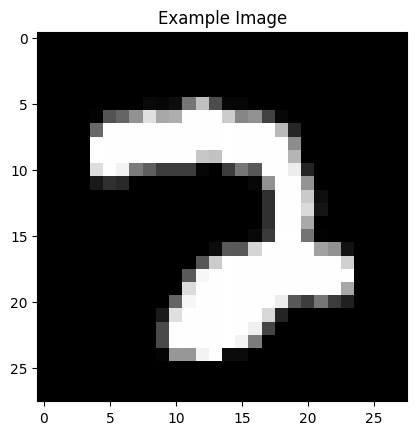

In [3]:
# set data and query paths
data_path = dataset
query_path = queryset

# load data and query from paths
data = idx2numpy.convert_from_file(data_path)
query = idx2numpy.convert_from_file(query_path)

# display the reshaped image
plt.imshow(data[120], cmap='gray')
plt.title("Example Image")
plt.show()

In [4]:
# shape of data set
print("Data set shape: ",data.shape)

# shape of query set
print("Query set shape: ",query.shape)


Data set shape:  (60000, 28, 28)
Query set shape:  (10000, 28, 28)


# Data Preproccessing

Convert from 28x28 to 28x28x1

In [5]:
# underscored data and query hold the postproccessed data, and query sets
_data = data.reshape(-1, 28,28, 1)
_query = query.reshape(-1, 28,28, 1)

In [6]:
# shape of data set
print("Data set shape: ",_data.shape)

# shape of query set
print("Query set shape: ",_query.shape)

Data set shape:  (60000, 28, 28, 1)
Query set shape:  (10000, 28, 28, 1)


Change data type to float32

In [7]:
# change the data type of _data and _query to float32
_data = _data.astype('float32')
_query = _query.astype('float32')

_data.dtype, _query.dtype

(dtype('float32'), dtype('float32'))

Rescale values from [0, 255] to [0.0, 1.0]

In [8]:
np.max(_data), np.max(_query)

(255.0, 255.0)

In [9]:
_data = _data / np.max(_data)
_query = _query / np.max(_query)

In [10]:
np.max(_data), np.max(_query)

(1.0, 1.0)

Split the data into train, valid, ground

In [11]:
train_X,valid_X,train_ground,valid_ground = train_test_split(_data,
                                                             _data,
                                                             test_size=0.181,
                                                             random_state=333)

# Neural Network

In [12]:

# hyperparameters
batch_size = 128
epochs = 12

# input layer
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))

conv_shape = (3, 3)
filters = (64, 32, 16)

x = Conv2D(filters[0], conv_shape, activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters[1], conv_shape, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters[2], conv_shape, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# flatten
x = Flatten()(x)

# latent space
x = Dense(10, activation='sigmoid')(x)
x = BatchNormalization()(x)

# decoder
x = Dense(4 * 4 * filters[2], activation='relu')(x)
x = Reshape((4, 4, filters[2]))(x)

x = Conv2D(filters[2], conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(filters[1], conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(filters[0], conv_shape, activation='relu')(x)
x = UpSampling2D((2, 2))(x)

# output layer
decoded = Conv2D(1, conv_shape, activation='sigmoid', padding='same')(x)

# autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())

autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)        128   

In [13]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/12
384/384 [==============================] - 234s 595ms/step - loss: 0.0535 - val_loss: 0.0573
Epoch 2/12
384/384 [==============================] - 227s 591ms/step - loss: 0.0329 - val_loss: 0.0279
Epoch 3/12
384/384 [==============================] - 233s 607ms/step - loss: 0.0275 - val_loss: 0.0260
Epoch 4/12
384/384 [==============================] - 228s 594ms/step - loss: 0.0251 - val_loss: 0.0227
Epoch 5/12
384/384 [==============================] - 229s 596ms/step - loss: 0.0234 - val_loss: 0.0234
Epoch 6/12
384/384 [==============================] - 228s 593ms/step - loss: 0.0224 - val_loss: 0.0222
Epoch 7/12
384/384 [==============================] - 236s 615ms/step - loss: 0.0216 - val_loss: 0.0222
Epoch 8/12
384/384 [==============================] - 292s 759ms/step - loss: 0.0209 - val_loss: 0.0199
Epoch 9/12
384/384 [==============================] - 245s 638ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 10/12
384/384 [==============================] - 233s 606m

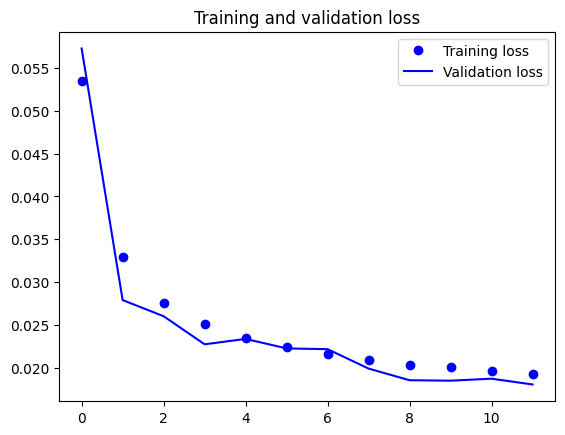

In [14]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
pred = autoencoder.predict(_query)



313/313 [==============================] - 12s 36ms/step


In [16]:
pred.shape



(10000, 28, 28, 1)

Test Images


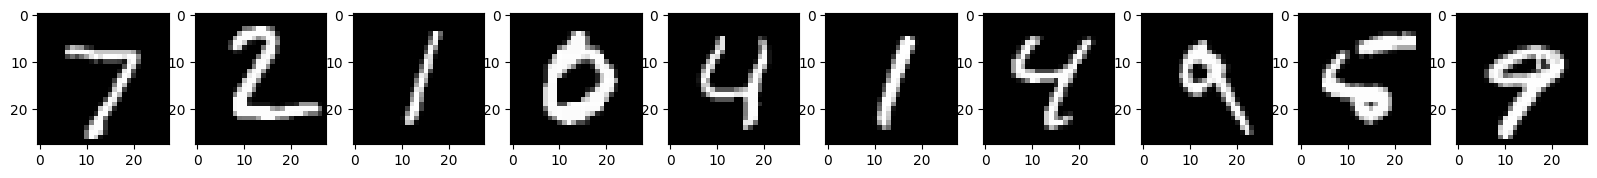

Reconstruction of Test Images


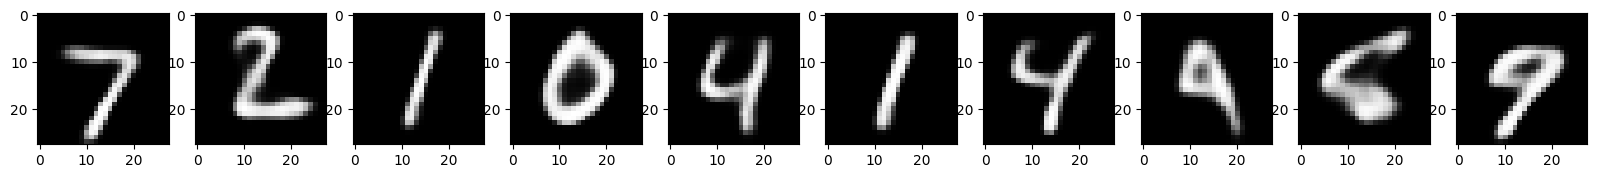

In [17]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(_query[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()

# Create Output In Latent Space

In [18]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)


In [19]:
query_bottleneck_output = encoder_model.predict(_query)

313/313 [==============================] - 6s 19ms/step


In [20]:
query_bottleneck_output.shape

(10000, 10)

In [21]:
query_bottleneck_output*=255
query_bottleneck_output=query_bottleneck_output.astype(int)
query_bottleneck_output[0]

array([191, 133, 137, 204, 143, 117, 139, 115, 113,  91])

In [22]:
data_bottleneck_output = encoder_model.predict(_data)

1875/1875 [==============================] - 32s 17ms/step


In [23]:
data_bottleneck_output.shape

(60000, 10)

In [24]:
data_bottleneck_output*=255
data_bottleneck_output=data_bottleneck_output.astype(int)
data_bottleneck_output[0]

array([ 94,  67,  95, 153, 138, 131, 108,  46, 162,  98])

In [25]:
data_bottleneck_output[0]

array([ 94,  67,  95, 153, 138, 131, 108,  46, 162,  98])

In [27]:
np.savetxt(output_dataset_file, data_bottleneck_output, delimiter=',', fmt='%d')
np.savetxt(output_query_file, query_bottleneck_output, delimiter=',', fmt='%d')